In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1. CSV Data
aisles = pd.read_csv('Daten/aisles.csv')
departments = pd.read_csv('Daten/departments.csv')
order_products = pd.read_csv('Daten/order_products_s.csv')
orders = pd.read_csv('Daten/orders_s.csv')
products = pd.read_csv('Daten/products.csv')
tips = pd.read_csv('Daten/tips.csv')

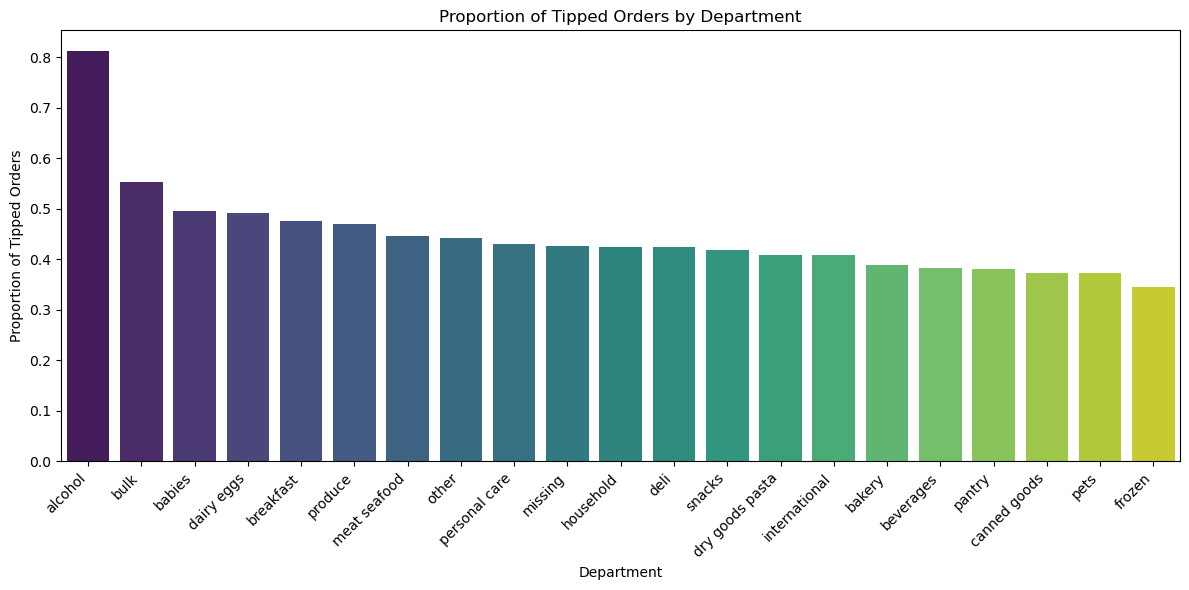

Chi-square Test Results
Chi2 statistic: 199364.85
P-value: 0.0000e+00
Degrees of Freedom: 20
Conclusion: There is a significant association between tipping behavior and the department.


In [ ]:
# Merge datasets
merged_data = (order_products
               .merge(products, on='product_id')
               .merge(departments, on='department_id')
               .merge(orders, on='order_id')
               .merge(tips, on='order_id'))

# Aggregate data: Percentage of orders with tips by department
department_tip_rate = (merged_data.groupby('department')['tip']
                       .mean()  # Calculate the proportion of True (tipped orders)
                       .reset_index()
                       .sort_values(by='tip', ascending=False))

# Visualize the percentage of tipped orders by department
plt.figure(figsize=(12, 6))
sns.barplot(data=department_tip_rate, x='department', y='tip', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Proportion of Tipped Orders by Department')
plt.ylabel('Proportion of Tipped Orders')
plt.xlabel('Department')
plt.tight_layout()
plt.show()

# Statistical analysis: Chi-square test to check association
# Create a contingency table: Count of tipped vs. non-tipped orders by department
contingency_table = pd.crosstab(merged_data['tip'], merged_data['department'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square Test Results")
print(f"Chi2 statistic: {chi2:.2f}")
print(f"P-value: {p:.4e}")
print(f"Degrees of Freedom: {dof}")
if p < 0.05:
    print("Conclusion: There is a significant association between tipping behavior and the department.")
else:
    print("Conclusion: There is no significant association between tipping behavior and the department.")

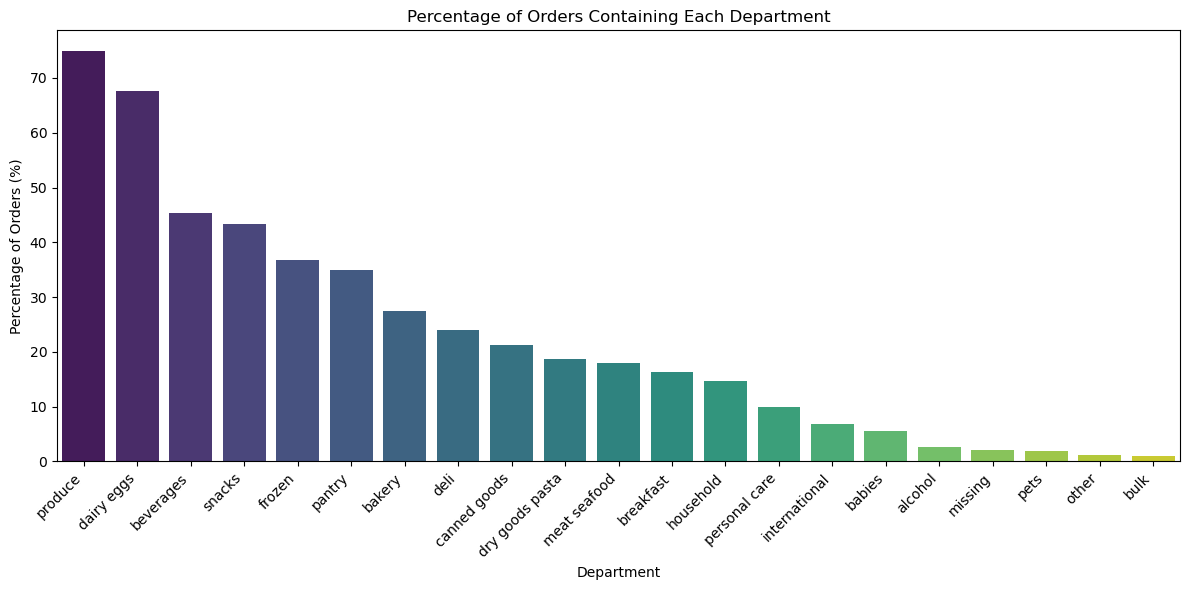

In [14]:
# Berechnung der Häufigkeit jedes Departments in den Bestellungen
department_order_count = merged_data.groupby('department')['order_id'].nunique()

# Prozentuale Verteilung berechnen
total_orders = merged_data['order_id'].nunique()  # Gesamtzahl der Bestellungen
department_percentage = (department_order_count / total_orders) * 100

# Sortierung nach Prozentwerten
department_percentage = department_percentage.sort_values(ascending=False).reset_index()
department_percentage.columns = ['department', 'percentage']

# Visualisierung der prozentualen Verteilung
plt.figure(figsize=(12, 6))
sns.barplot(data=department_percentage, x='department', y='percentage', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Orders Containing Each Department')
plt.ylabel('Percentage of Orders (%)')
plt.xlabel('Department')
plt.tight_layout()
plt.show()


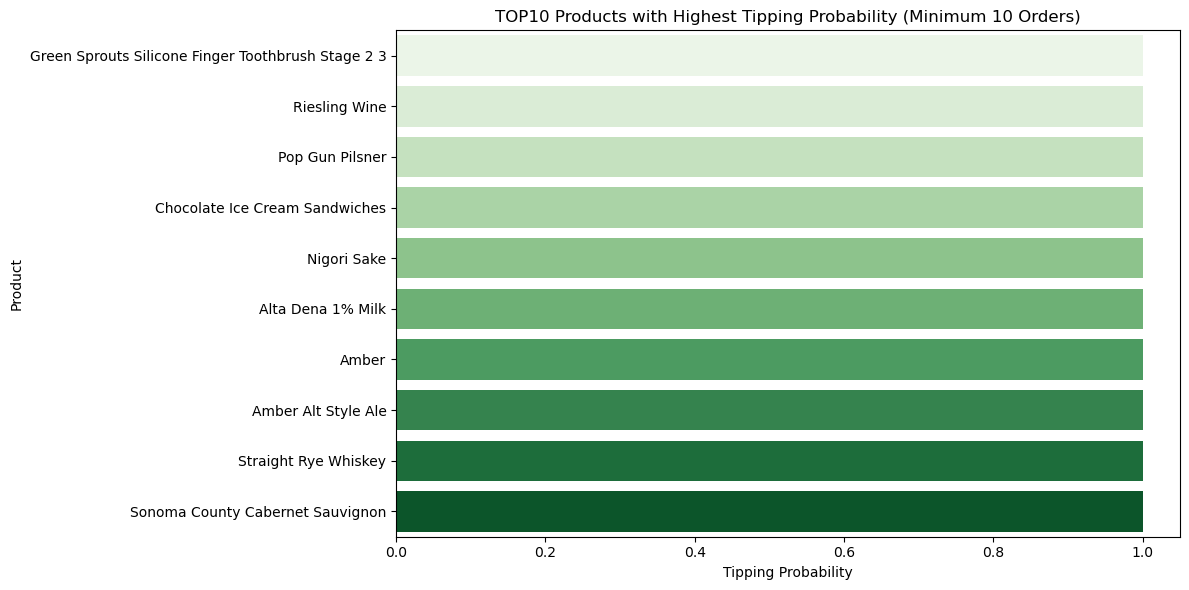

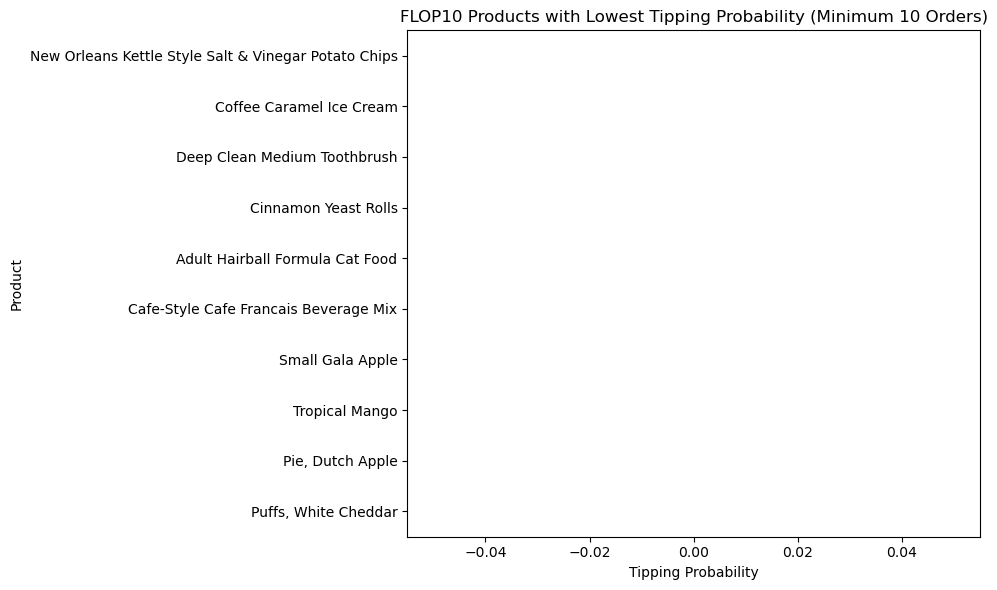

TOP10 Products with Highest Tipping Probability (Minimum 10 Orders):
                                            product_name  total_tips  \
18496  Green Sprouts Silicone Finger Toothbrush Stage...          13   
37952                                      Riesling Wine          12   
35138                                    Pop Gun Pilsner          13   
8452                      Chocolate Ice Cream Sandwiches          15   
27133                                        Nigori Sake          14   
2212                                   Alta Dena 1% Milk          10   
2241                                               Amber          10   
2244                                 Amber Alt Style Ale          29   
42516                               Straight Rye Whiskey          11   
41135                   Sonoma County Cabernet Sauvignon          10   

       total_orders  tip_probability  
18496            13              1.0  
37952            12              1.0  
35138            13  

In [6]:
# Calculate total tips and total orders for each product
product_tips_orders = merged_data.groupby('product_name').agg(
    total_tips=('tip', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

# Filter products with at least 10 orders
product_tips_orders = product_tips_orders[product_tips_orders['total_orders'] >= 10]

# Calculate tip probability as tips/orders
product_tips_orders['tip_probability'] = product_tips_orders['total_tips'] / product_tips_orders['total_orders']

# Sort by tip probability
product_tips_orders = product_tips_orders.sort_values(by='tip_probability', ascending=False)

# Get TOP10 and FLOP10 products
top10_products = product_tips_orders.head(10)
flop10_products = product_tips_orders.tail(10)

# Visualize TOP10 products
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_products, x='tip_probability', y='product_name', palette='Greens')
plt.title('TOP10 Products with Highest Tipping Probability (Minimum 10 Orders)')
plt.xlabel('Tipping Probability')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Visualize FLOP10 products
plt.figure(figsize=(10, 6))
sns.barplot(data=flop10_products, x='tip_probability', y='product_name', palette='Reds')
plt.title('FLOP10 Products with Lowest Tipping Probability (Minimum 10 Orders)')
plt.xlabel('Tipping Probability')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Display the results
print("TOP10 Products with Highest Tipping Probability (Minimum 10 Orders):")
print(top10_products)

print("\nFLOP10 Products with Lowest Tipping Probability (Minimum 10 Orders):")
print(flop10_products)

print(product_tips_orders)


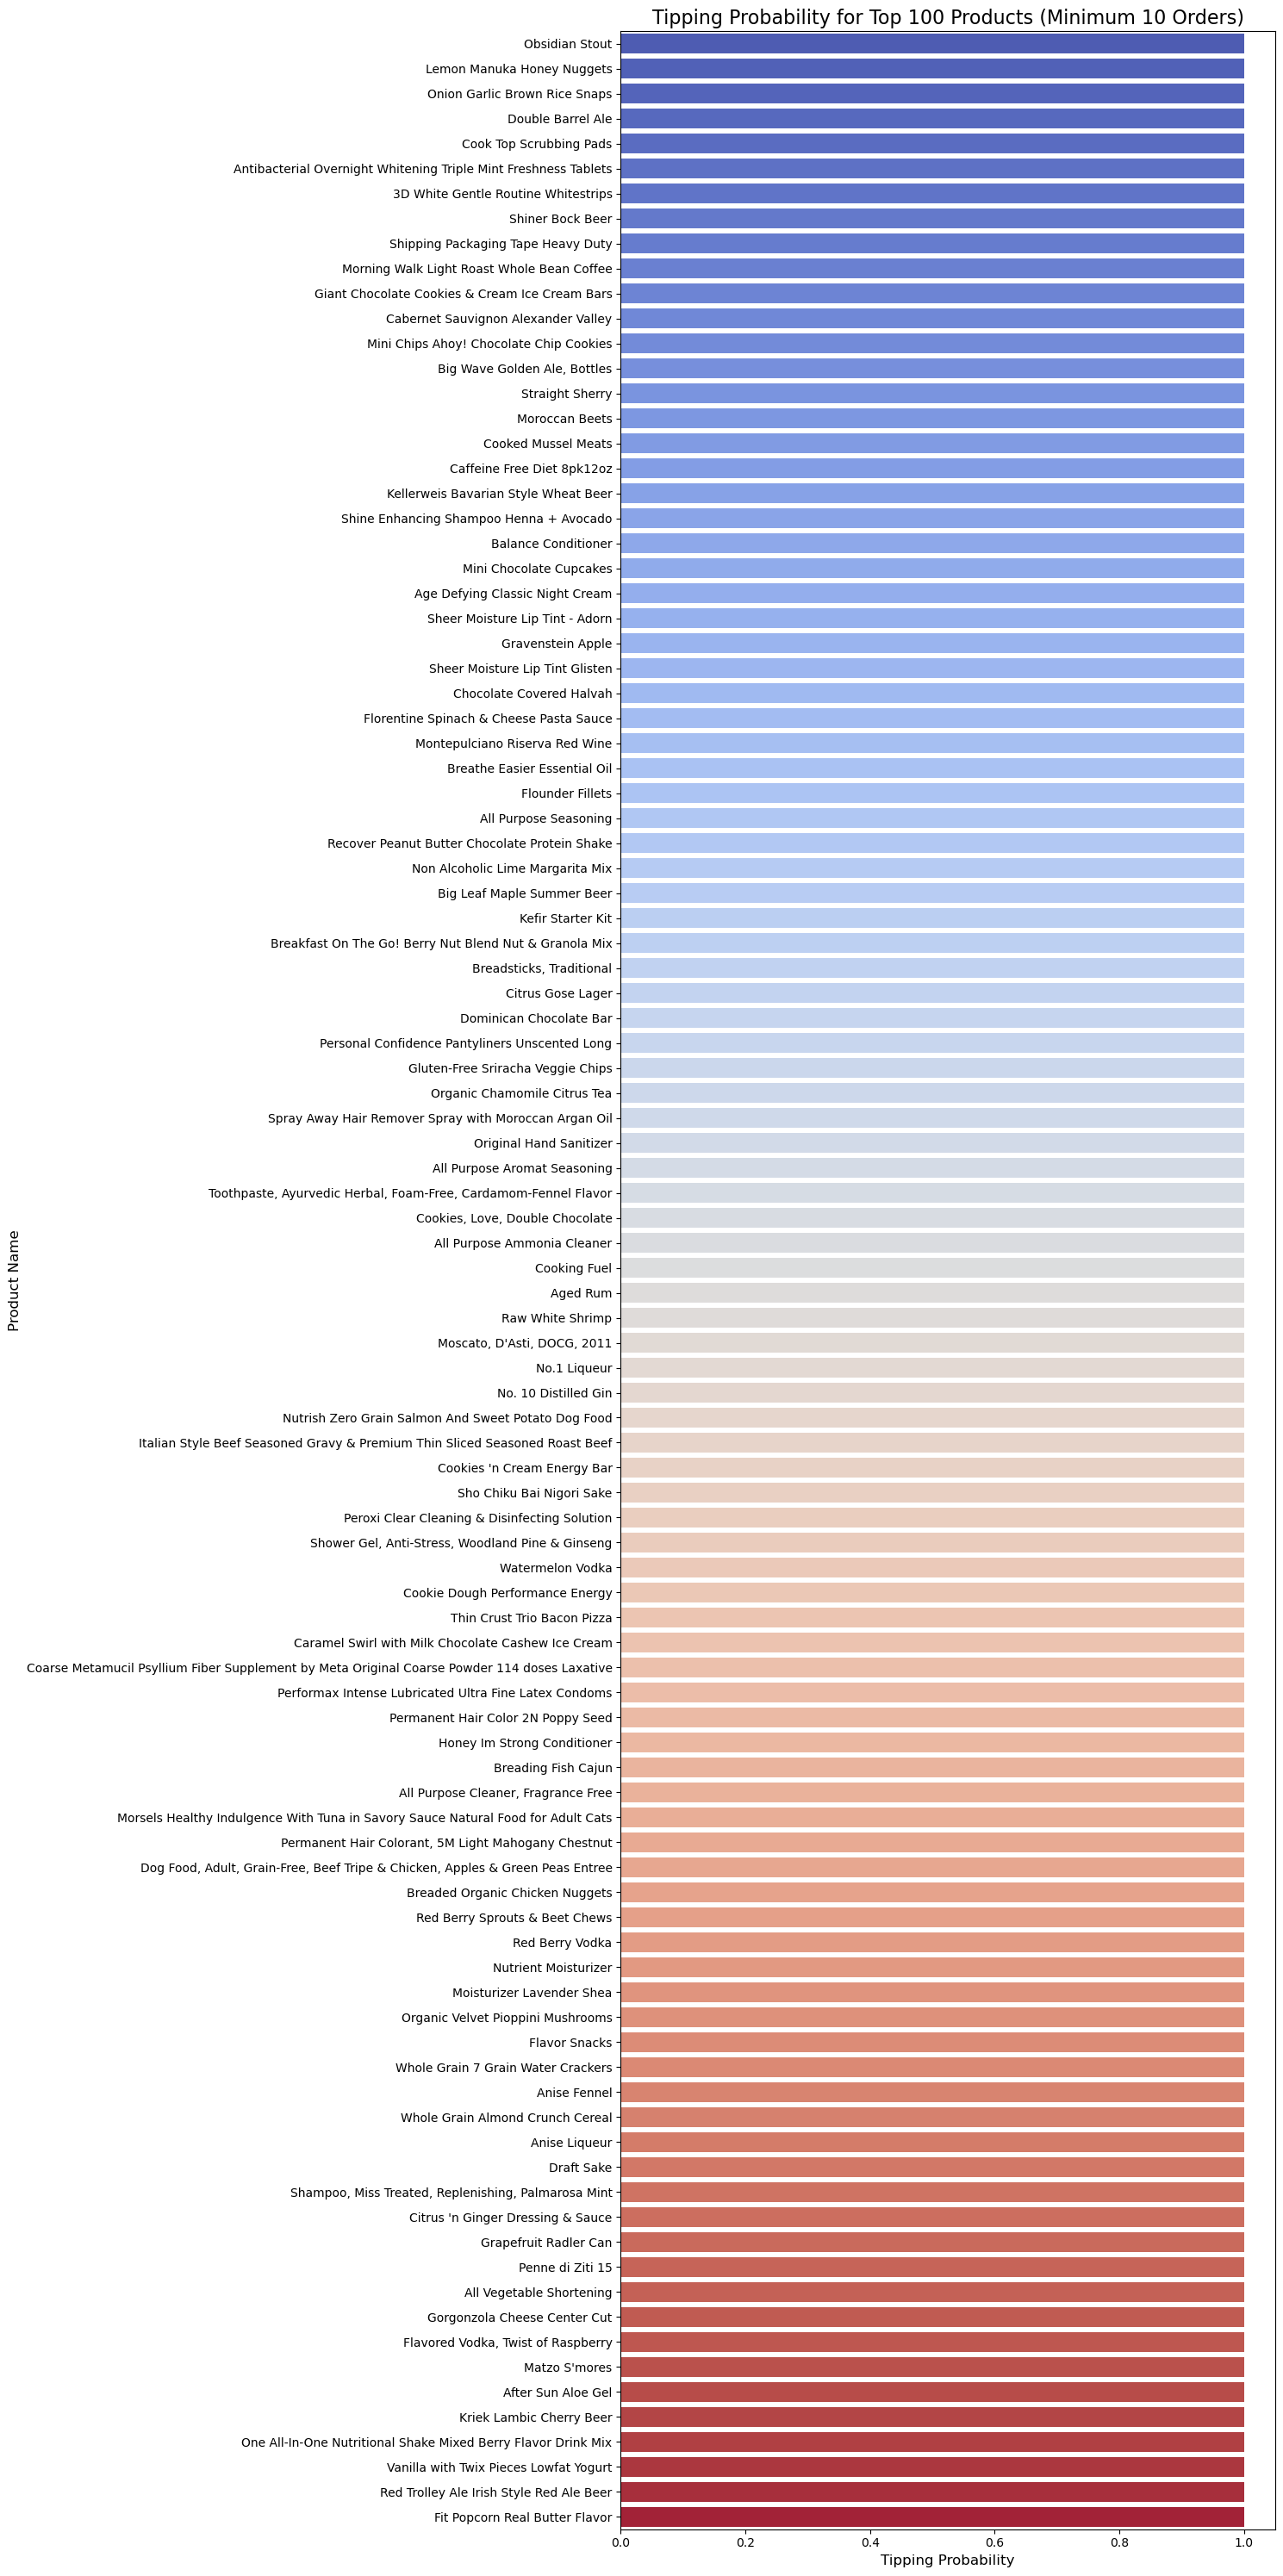

In [4]:
# Set the maximum number of products to display
max_products = 100  # Change this to adjust the number of products displayed

# Take the top N products based on tip probability
products_to_plot = product_tips_orders.head(max_products)

# Plot the selected products
plt.figure(figsize=(15, len(products_to_plot) * 0.3))  # Adjust figure height dynamically
sns.barplot(
    data=products_to_plot,
    x='tip_probability',
    y='product_name',
    palette='coolwarm'
)

# Add labels and title
plt.title(f'Tipping Probability for Top {max_products} Products (Minimum 10 Orders)', fontsize=16)
plt.xlabel('Tipping Probability', fontsize=12)
plt.ylabel('Product Name', fontsize=12)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report
import numpy as np

# Prepare data
# One-hot encode departments and top/bottom products
merged_data['is_top_product'] = merged_data['product_name'].isin(top10_products['product_name'])
merged_data['is_flop_product'] = merged_data['product_name'].isin(flop10_products['product_name'])

# One-hot encode department
encoder = OneHotEncoder(drop='first', sparse_output=False)
departments_encoded = encoder.fit_transform(merged_data[['department']])
department_columns = encoder.get_feature_names_out(['department'])

# Create feature set
X = pd.DataFrame(departments_encoded, columns=department_columns)
X['is_top_product'] = merged_data['is_top_product']
X['is_flop_product'] = merged_data['is_flop_product']

# Target variable
y = merged_data['tip']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model 1: Using department only
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train[department_columns], y_train)

# Model 2: Adding specific products
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(X_train, y_train)

# Evaluate models
log_loss_1 = log_loss(y_test, model_1.predict_proba(X_test[department_columns]))
log_loss_2 = log_loss(y_test, model_2.predict_proba(X_test))

print(f"Log Loss (Model 1 - Department Only): {log_loss_1:.7f}")
print(f"Log Loss (Model 2 - Department + Products): {log_loss_2:.7f}")

# Compare models
if log_loss_2 < log_loss_1:
    print("Adding specific products improves the model, indicating they have an additional effect on tipping probability.")
elif log_loss_1 == log_loss_1:
    print("Same result")
else:
    print("Spezi")

# Optional: Examine coefficients for interpretation
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_2.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nTop Features Influencing Tipping Probability:")
print(coefficients.head(10))


Log Loss (Model 1 - Department Only): 0.6795520
Log Loss (Model 2 - Department + Products): 0.6795522
Same result

Top Features Influencing Tipping Probability:
                     Feature  Coefficient
20            is_top_product     0.042127
21           is_flop_product    -0.022232
4            department_bulk    -1.170995
0          department_babies    -1.419452
6      department_dairy eggs    -1.438335
3       department_breakfast    -1.504969
18        department_produce    -1.523186
12   department_meat seafood    -1.615991
16  department_personal care    -1.660259
10      department_household    -1.699549
